# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.optim import lr_scheduler

from torchvision import datasets, models, transforms
import torchvision.models as models

import matplotlib.pyplot as plt

from PIL import Image
import time
import json

from collections import OrderedDict

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [4]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [5]:
# TODO: Define your transforms for the training, validation, and testing sets
# Split data transforms into 3: train_transforms, test_transforms, validate_transforms

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

validate_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])


# TODO: Load the datasets with ImageFolder
# Separate datasets by use: train, test, validate

train_data = datasets.ImageFolder(train_dir, transform = train_transforms)
test_data = datasets.ImageFolder(test_dir, transform = test_transforms)
validate_data = datasets.ImageFolder(valid_dir, transform = validate_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
# Separate dataloaders by use: train, test, validate

# Note: Set shuffle=True to ensure order of images does not impact model

train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 32, shuffle = True)
validate_loader = torch.utils.data.DataLoader(validate_data, batch_size = 32, shuffle = True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [21]:
# TODO: Build and train your network - we will follow the sequence below

# Plan as follows:
# 1. Load pre-trained network model
# 2. Freeze weights of pretrained model, to prevent us from backproppagating through/updating them
# 3. Define untrained feed forward network model as classifier
# 4. Determine criterion and optimiser algorithm
# 5. Create a function for model validation
# 6. Train the network model

In [65]:
# 1. Load pre-trained network model
# Decision made to use VGG16 pretrained model as it is simpler than the other models, 
# as it uses 3x3 convolution and 2x2 pooling. VGG16 has a substantial depth of network which gives better results.
model_architecture = 'vgg16'
model = getattr(models,model_architecture)(pretrained=True)
# model = models.vgg16(pretrained = True)

# Quick look at the models parameters 

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [66]:
# 2. Freeze weights of pretrained model, to prevent us from backproppagating through/updating them

for param in model.parameters():
    param.requires_grad = False

In [67]:
# 3. Define untrained feed forward network model as classifier

# Identify the count of in_features
features_count = model.classifier[0].in_features

# Specify the new model classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(features_count, 512)),
                                        ('relu', nn.ReLU()),
                                        ('dropout1', nn.Dropout(0.05)), 
                                        ('fc2', nn.Linear(512, 102)),
                                        ('output', nn.LogSoftmax(dim=1))]))

# Replace the model classifier
model.classifier = classifier

In [68]:
# 4. Determine criterion and optimiser algorithm
    
# Using a NLLLoss as output is LogSoftmax
criterion = nn.NLLLoss()


# Using Adam optimiser algorithm - uses concept of momentum to add fractions 
# to previous gradient descents to minimize loss function
optimizer = optim.Adam(model.classifier.parameters(), lr= 0.001)

In [69]:
# 5. Create a function for model validation 

def validation(model, validate_loader, criterion):
    valid_loss = 0
    accuracy = 0
    
    # change model to work with cuda
    model.to('cuda')

    # Iterate over data from validate_loader
    for ii, (images, labels) in enumerate(validate_loader):
    
        # Change images and labels to work with cuda
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass image though model for prediction
        output = model.forward(images)
        # Calculate loss
        valid_loss += criterion(output, labels).item()
        # Calculate probability
        ps = torch.exp(output)
        
        # Calculate accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return valid_loss, accuracy

In [70]:
# 6.1 Train the network model - Define the parameters

epochs = 1
steps = 0
print_every_x_step = 10

# change to gpu mode
model.to('cuda')


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [31]:
# 6.2 Train the network model - Execute training
# NOTE*** - COMMENT OUT IF NOT NEEDED TO RETRAIN THE MODEL (CAN LOAD PREVIOUSLY TRAINED MODEL FROM 'checkpoint.pth')

for e in range(epochs):
    since = time.time()
    running_loss = 0
    
    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(train_loader):
        steps += 1
        
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        # zeroing parameter gradients
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Carrying out validation step
        if steps % print_every_x_step == 0:
            # setting model to evaluation mode during validation
            model.eval()
            
            # Gradients are turned off as no longer in training
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validate_loader, criterion)
                
            print(f"No. epochs: {e+1}, \
            Training Loss: {round(running_loss/print_every_x_step,3)} \
            Valid Loss: {round(valid_loss/len(validate_loader),3)} \
            Valid Accuracy: {round(float(accuracy/len(validate_loader)),3)}")
            
            running_loss = 0
            
            # Turning training back on
            model.train()
            
    time_taken = time.time() - since
    print(f"Time taken for epoch: {time_taken} seconds")

No. epochs: 1,             Training Loss: 4.886             Valid Loss: 3.721             Valid Accuracy: 0.271
No. epochs: 1,             Training Loss: 3.523             Valid Loss: 2.778             Valid Accuracy: 0.404
No. epochs: 1,             Training Loss: 2.821             Valid Loss: 2.12             Valid Accuracy: 0.515
No. epochs: 1,             Training Loss: 2.41             Valid Loss: 1.644             Valid Accuracy: 0.62
No. epochs: 1,             Training Loss: 1.98             Valid Loss: 1.303             Valid Accuracy: 0.669
No. epochs: 1,             Training Loss: 1.831             Valid Loss: 1.147             Valid Accuracy: 0.709
No. epochs: 1,             Training Loss: 1.564             Valid Loss: 1.043             Valid Accuracy: 0.739
No. epochs: 1,             Training Loss: 1.557             Valid Loss: 0.914             Valid Accuracy: 0.775
No. epochs: 1,             Training Loss: 1.432             Valid Loss: 0.812             Valid Accuracy: 0.

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [32]:
# TODO: Do validation on the test set

def calc_model_accuracy_on_test(test_loader):    
    correct = 0
    total = 0
    model.to('cuda')
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            
            # Calculate probabilities of what label fits the image 
            outputs = model(images)
            
            # Convert probabilities into actual predicted label
            _, predicted = torch.max(outputs.data, 1)
            
            # Count total number of images
            total += labels.size(0)
            
            # Count instances where predicted label == correct label
            correct += (predicted == labels).sum().item()

    print('Model accuracy - applied to test images: %d %%' % (100 * correct / total))
    

calc_model_accuracy_on_test(test_loader)

Model accuracy - applied to test images: 73 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [73]:
# TODO: Save the checkpoint 

model.class_to_idx = train_data.class_to_idx

# Define checkpoint features to be saved
checkpoint = {'classifier': model.classifier,
              'opt_state':optimizer.state_dict,
            'state_dict':model.state_dict(),
            'class_to_idx':model.class_to_idx,
             'num_epochs': epochs,
             'arch': model_architecture}

# Saving the checkpoint
torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [74]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    
    # Loan the checkpoint
    checkpoint = torch.load(filepath)
    
    # Rebuild the model
#     model = getattr(models,checkpoint['arch'])(pretrained=True)
    
    model.load_state_dict(checkpoint['state_dict'])
    model.classifier = checkpoint['classifier'] 
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [75]:
# Loading model using the function
model = load_checkpoint('checkpoint.pth')

# Quick look at loaded model
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [76]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    # Use PIL to load image
    pil_image = Image.open(image)

    # Required transformation to the loaded image 
    # - resize to 256 pixels
    # - center crop 224x224
    # - normalise using means[0.485, 0.456, 0.406] and std devs[0.229, 0.224, 0.225]     

    # Resize to targeted size    
    width, height = pil_image.size
    size = 256
    shortest_side = min(width, height)
    pil_image_resized = pil_image.resize((int((width/shortest_side)*size) , int((height/shortest_side)*size)))

    # Perform a center crop
    cent_crop_size = 224
    cent_crop_value = 0.5 * (size - cent_crop_size)                                                                      
    pil_image_cropped =pil_image_resized.crop((cent_crop_value,
                                              cent_crop_value,
                                              size-cent_crop_value,
                                              size-cent_crop_value))                                         
    # Convert to array
    pil_image_array = np.array(pil_image_cropped)
    pil_image_np = pil_image_array/255
    
    # Normalisation of image                                         
    normalize_mean = np.array([0.485, 0.456, 0.406])
    normalize_std = np.array([0.229, 0.224, 0.225])                                    
    pil_image_np_normalized = (pil_image_np - normalize_mean) / normalize_std
                                         
    # Apply transformation to loaded image
    transform = transforms.Compose([transforms.ToTensor()])
    pil_image_transformed = transform(pil_image_np_normalized)    
    
    return pil_image_transformed
        

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [77]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

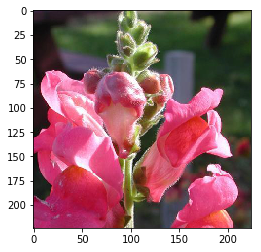

In [78]:
# Apply 'process_image' function on a test image
test_image_name = data_dir + '/test' + '/11/' + 'image_03130.jpg'
test_image_processed = process_image(test_image_name)

# Apply 'imshow' function to test if the processed image, when transformations are reversed,
# results in the correct original image
imshow(test_image_processed, ax=None, title=None)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [79]:
def predict(image_path, model, topk=5):   
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''    
    
    # TODO: Implement the code to predict the class from an image file
    model.to('cuda')
    input_image_raw = process_image(image_path)
    
    input_image_unsqueezed = input_image_raw.unsqueeze_(0)
    input_image_torch = input_image_unsqueezed.float()
    
    # Feeding the input image through the model
    with torch.no_grad():
        output_result = model.forward(input_image_torch.cuda())

    # Calc probabilities
    probs_raw = torch.exp(output_result)
    probs_topk = probs_raw.topk(topk)[0]
    index_topk = probs_raw.topk(topk)[1]

    # Converting probabilities and outputs to lists
    probs_topk_list = np.array(probs_topk)[0]
    index_topk_list = np.array(index_topk[0])    
    
    # Loading the class to index, then inverting into index to class
    class_to_idx = model.class_to_idx
    idx_to_class = {x: y for y, x in class_to_idx.items()}        

    # Converting index list to class list
    classes_topk_list = []
    for index in index_topk_list:
        classes_topk_list += [idx_to_class[index]]
        
    return probs_topk_list, classes_topk_list


    # TODO: Implement the code to predict the class from an image file

In [80]:
# Use the Loaded model
loaded_model = load_checkpoint('checkpoint.pth')

# Select an image and predict
test_predict_image_name = data_dir + '/test' + '/8/' + 'image_03291.jpg'
probs, classes = predict(test_predict_image_name, loaded_model, 5)

# Converting classes to names
classes_names = []
for i in classes:
    classes_names += [cat_to_name[i]]

# Print results    
print('Probabilities: {}'.format(probs))
print('Class number: {}'.format(classes))
print('Class name: {}'.format(classes_names))

Probabilities: [  9.99314547e-01   1.60595169e-04   1.40328717e-04   8.06598109e-05
   6.87555366e-05]
Class number: ['8', '88', '99', '61', '24']
Class name: ['bird of paradise', 'cyclamen', 'bromelia', 'cautleya spicata', 'red ginger']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [81]:
# TODO: Display an image along with the top 5 classes

# Incorp predict into it
# Change the type of flower

# def view_classify(img, probabilities, classes, mapper):
def predict_classify(image_path, model, num_classifications):    
    ''' Function for viewing an image and it's predicted classes.
    '''
    # Create PIL image
    image_show = Image.open(image_path)
    image_filename = image_path.split('/')[-2]
    
    # Perform prediction
    probs, classes = predict(image_path, model, num_classifications)
        
    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    
    # Actual flower name
    flower_name = cat_to_name[image_filename]
    
    # Charting/Viz
    ax1.set_title(flower_name)
    ax1.imshow(image_show)
    ax1.axis('off')
    
    y_pos = np.arange(len(probs))
    ax2.barh(y_pos, probs)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([cat_to_name[x] for x in classes])
    ax2.invert_yaxis()   
    

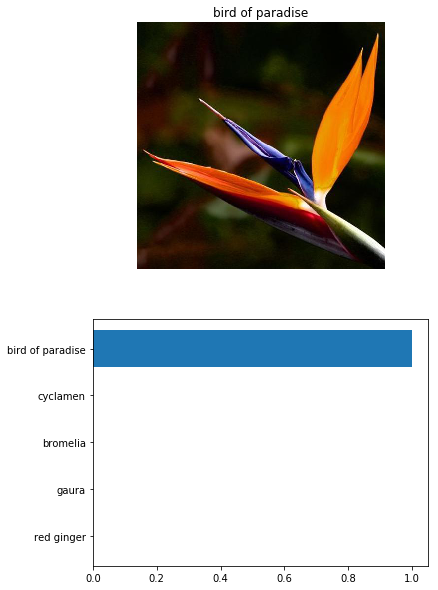

In [82]:
# Select image for prediction and classification
test_classify_image_name = data_dir + '/test' + '/8/' + 'image_03291.jpg'

# Perform prediction and return classification
predict_classify(test_classify_image_name, model, 5)

## References

 - Logic for function to schedule learning rate, saving the best model: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
 - Pretrained models sourced from: https://pytorch.org/docs/master/torchvision/models.html
 - Quick information about VGG model: https://www.quora.com/What-is-the-VGG-neural-network
 - Choosing between NLLLoss and CrossEntropyLoss: https://discuss.pytorch.org/t/does-nllloss-handle-log-softmax-and-softmax-in-the-same-way/8835
 - Optimiser algorithms: https://pytorch.org/docs/stable/optim.html
 - Optimiser scheduler: https://pytorch.org/docs/stable/optim.html
 - Learning rates: https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10
 
 